#### Project Proposal: Medical Appointments No Shows (Part 2)

Data:
https://www.kaggle.com/joniarroba/noshowappointments


- rate of appointments? up or down?
- patients reporting on time of their scheduled appointments? yes/no
- determine characteristics of patients to show up - enable to take countermeasure (constant appointment reminders, doctors & hospital staff adequate with demand)

In [1]:
# Notebook setup
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Common imports
import numpy as np
import pandas as pd
import os
from pathlib import Path

import pylab as plt

import datetime as dt

# Plotting imports and settings
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,8)
import seaborn as sns

# To make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Term Project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#### Exploratory Data Analysis

In [3]:
# Read in data into a dataframe 
data = pd.read_csv('data/KaggleV2-May-2016.csv')

# Display top of dataframe
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Remove negative values
data = data[data['Age'] >= 0]

In [5]:
# Recode Gender & Status to integers
data['Gender_1'] = data['Gender'].map({"M":1, "F":0}).astype(int)
data['Labels'] = data['No-show'].map({"Yes":1, "No":0}).astype(int)

In [6]:
# Convert date objects to datetime format (without time part)
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDay']).dt.date
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDayDT'])
data['AppointmentDayDT'] = pd.to_datetime(data['AppointmentDay']).dt.date
data['AppointmentDayDT'] = pd.to_datetime(data['AppointmentDayDT'])

In [7]:
data['MonthAppt'] = data['AppointmentDayDT'].dt.month
data['MonthScheduled'] = data['ScheduledDayDT'].dt.month

In [8]:
# Create new feature: "AwaitingTime" - no. of days between scheduled date and appointment date
data['time_between_appts'] = data['AppointmentDayDT']- data['ScheduledDayDT']
data['AwaitingTime'] = data['time_between_appts']/np.timedelta64(1,'D')

In [9]:
# Create new features - day of the week scheduled and appointment dates
data['DayAppt'] = data['AppointmentDayDT'].dt.dayofweek
data['DayScheduled'] = data['ScheduledDayDT'].dt.dayofweek

In [10]:
# keep only desired features and labels
data1 = data[['Gender','Age','Hipertension','Diabetes','Alcoholism','SMS_received','Scholarship',
              'DayScheduled','DayAppt','AwaitingTime', 'MonthAppt', 'MonthScheduled', 'Labels']]

In [11]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,110526.0,37.089219,23.110026,0.0,18.0,37.0,55.0,115.0
Hipertension,110526.0,0.197248,0.397923,0.0,0.0,0.0,0.0,1.0
Diabetes,110526.0,0.071865,0.258266,0.0,0.0,0.0,0.0,1.0
Alcoholism,110526.0,0.030400,0.171686,0.0,0.0,0.0,0.0,1.0
SMS_received,110526.0,0.321029,0.466874,0.0,0.0,0.0,1.0,1.0
Scholarship,110526.0,0.098266,0.297676,0.0,0.0,0.0,0.0,1.0
DayScheduled,110526.0,1.851971,1.378515,0.0,1.0,2.0,3.0,5.0
DayAppt,110526.0,1.858260,1.371667,0.0,1.0,2.0,3.0,5.0
AwaitingTime,110526.0,10.183794,15.255034,-6.0,0.0,4.0,15.0,179.0
MonthAppt,110526.0,5.210041,0.473776,4.0,5.0,5.0,5.0,6.0


In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.kernel_approximation import RBFSampler


from sklearn.decomposition import PCA
from sklearn import kernel_approximation
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [13]:
# Split into train/test, stratify by Label column
train_set,test_set = train_test_split(data1,test_size=0.3) # stratify=data1['Labels'])
print(len(train_set), "train +", len(test_set), "test")

# Divide into features/labels
train_features = train_set.drop('Labels',axis=1)
train_labels = train_set[['Labels']]
test_features = test_set.drop('Labels',axis=1)
test_labels = test_set['Labels']

77368 train + 33158 test


In [14]:
test_features.shape

(33158, 12)

In [15]:
train_features.shape

(77368, 12)

In [16]:
# Transform numerical and categorical features using StandardScaler() and OneHotEncoder()

num_attribs = ['Age','AwaitingTime']
cat_attribs = ['Gender','Hipertension','Diabetes','Alcoholism','SMS_received','Scholarship',
              'DayAppt','DayScheduled','MonthAppt','MonthScheduled']

# Categorical subset to one-hot encode
cat_attribs_one_hot= ['Gender','DayAppt','DayScheduled','MonthAppt','MonthScheduled']

pipeline_features = ColumnTransformer([
    ("num",StandardScaler(),num_attribs),
     ("cat",OneHotEncoder(categories='auto'), cat_attribs_one_hot)
    ])

train_features_prepared = pipeline_features.fit_transform(train_features)
train_labels_prepared = train_labels.values

test_features_prepared = pipeline_features.transform(test_features)
test_labels_prepared = test_labels.values

In [17]:
train_features_prepared.shape

(77368, 27)

In [18]:
test_features_prepared.shape

(33158, 27)

In [19]:
df_train_features_prepared=pd.DataFrame(train_features_prepared.toarray())
df_train_features_prepared.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.426458,-0.666131,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.210162,0.182739,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.512976,-0.535535,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.611761,-0.339643,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.606720,1.162203,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
df_test_features_prepared=pd.DataFrame(test_features_prepared.toarray())
df_test_features_prepared.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-0.352206,-0.666131,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.006133,1.619286,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.037126,-0.143750,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.568501,1.358096,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.166903,-0.666131,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
# This Function Runs Several Classifiers on Training Data with 3 cv-folds, Prints Out "metric" score of each Model
 
def testClassifiers(train_features,train_labels,metric=[]):
    LOG=LogisticRegression()
    DTC=DecisionTreeClassifier()
    RFC=RandomForestClassifier(n_estimators=100)
    KNN=KNeighborsClassifier()
    SGD=SGDClassifier()
    SVC_CLF = SVC(kernel="rbf") #This runs very slow!

    classifier_list = [LOG,DTC,KNN,RFC,SGD,SVC_CLF]# RFC and SVC_CLF take long.

    for c in classifier_list:
        print(type(c).__name__)
        for m in metric:
            #can use cross_validate with multiple scores insteadto make this run faster
            cv_results = cross_val_score(c,train_features_prepared,train_labels_prepared,cv=3,scoring=m)
            print('-------------------')
            print('Scoring Metric: ', m)
            print('Scores: ',cv_results)
            print('Mean Score: ',np.round(np.mean(cv_results),2))
            print('')

In [22]:
# testClassifiers(train_features,train_labels, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [23]:
def model_performance(model_name, train_features_prepared, train_labels_prepared, 
                      test_labels_prepared, labels_pred):

    print ('Model name: %s' %model_name)
    print ('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(test_labels_prepared, labels_pred))
    print ('Test accuracy (ROC AUC Score): %f'%metrics.roc_auc_score(test_labels_prepared, labels_pred))
    print ('Train accuracy: %f'%clf.score(train_features_prepared, train_labels_prepared))

    fpr, tpr, thresholds = metrics.precision_recall_curve(test_labels_prepared, labels_pred)
    print ('Area Under the Precision-Recall Curve: %f'%metrics.auc(fpr, tpr))
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_labels_prepared, labels_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [24]:
clf = DecisionTreeClassifier()
clf.fit(train_features_prepared, train_labels_prepared)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Model name: Decision tree classifier
Test accuracy (Accuracy Score): 0.757193
Test accuracy (ROC AUC Score): 0.559276
Train accuracy: 0.897658
Area Under the Precision-Recall Curve: 0.162021


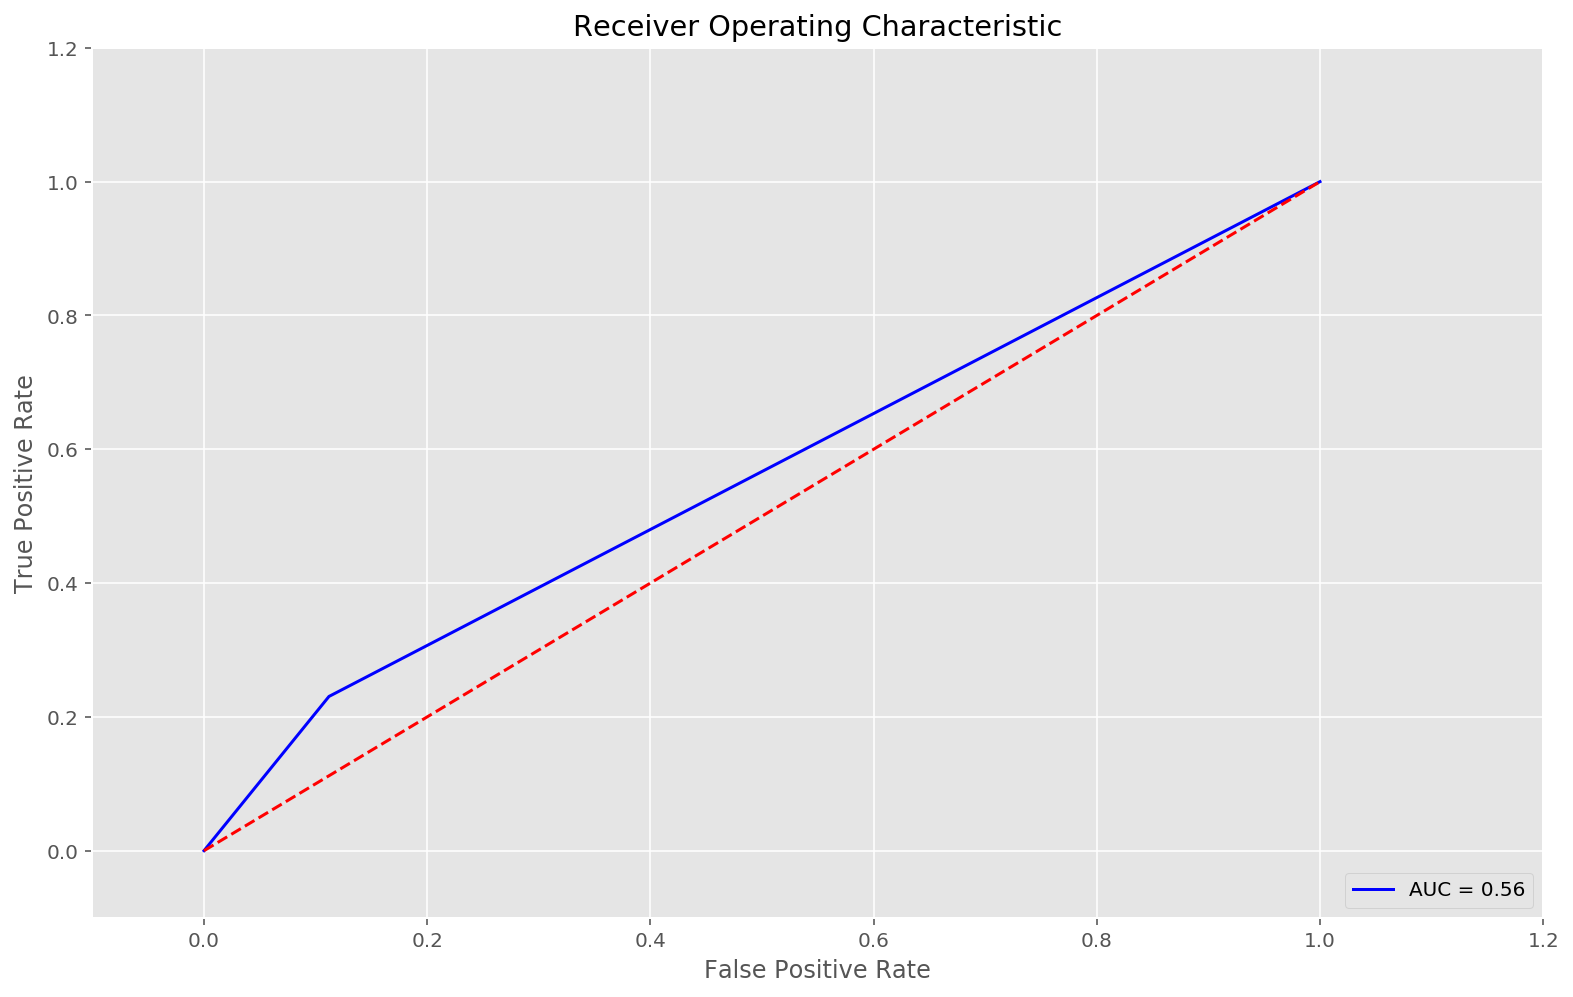

In [25]:
labels_pred = clf.predict(test_features_prepared)
model_performance('Decision tree classifier', train_features_prepared, train_labels_prepared, 
                  test_labels_prepared, labels_pred)

In [26]:
rbf_feature = kernel_approximation.RBFSampler(gamma=1, random_state=1)
train_features_prepared = rbf_feature.fit_transform(train_features_prepared)

clf = SGDClassifier()
clf.fit(train_features_prepared, train_labels_prepared)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Model name: Kernel approximation
Test accuracy (Accuracy Score): 0.801013
Test accuracy (ROC AUC Score): 0.500000
Train accuracy: 0.796802
Area Under the Precision-Recall Curve: 0.400507


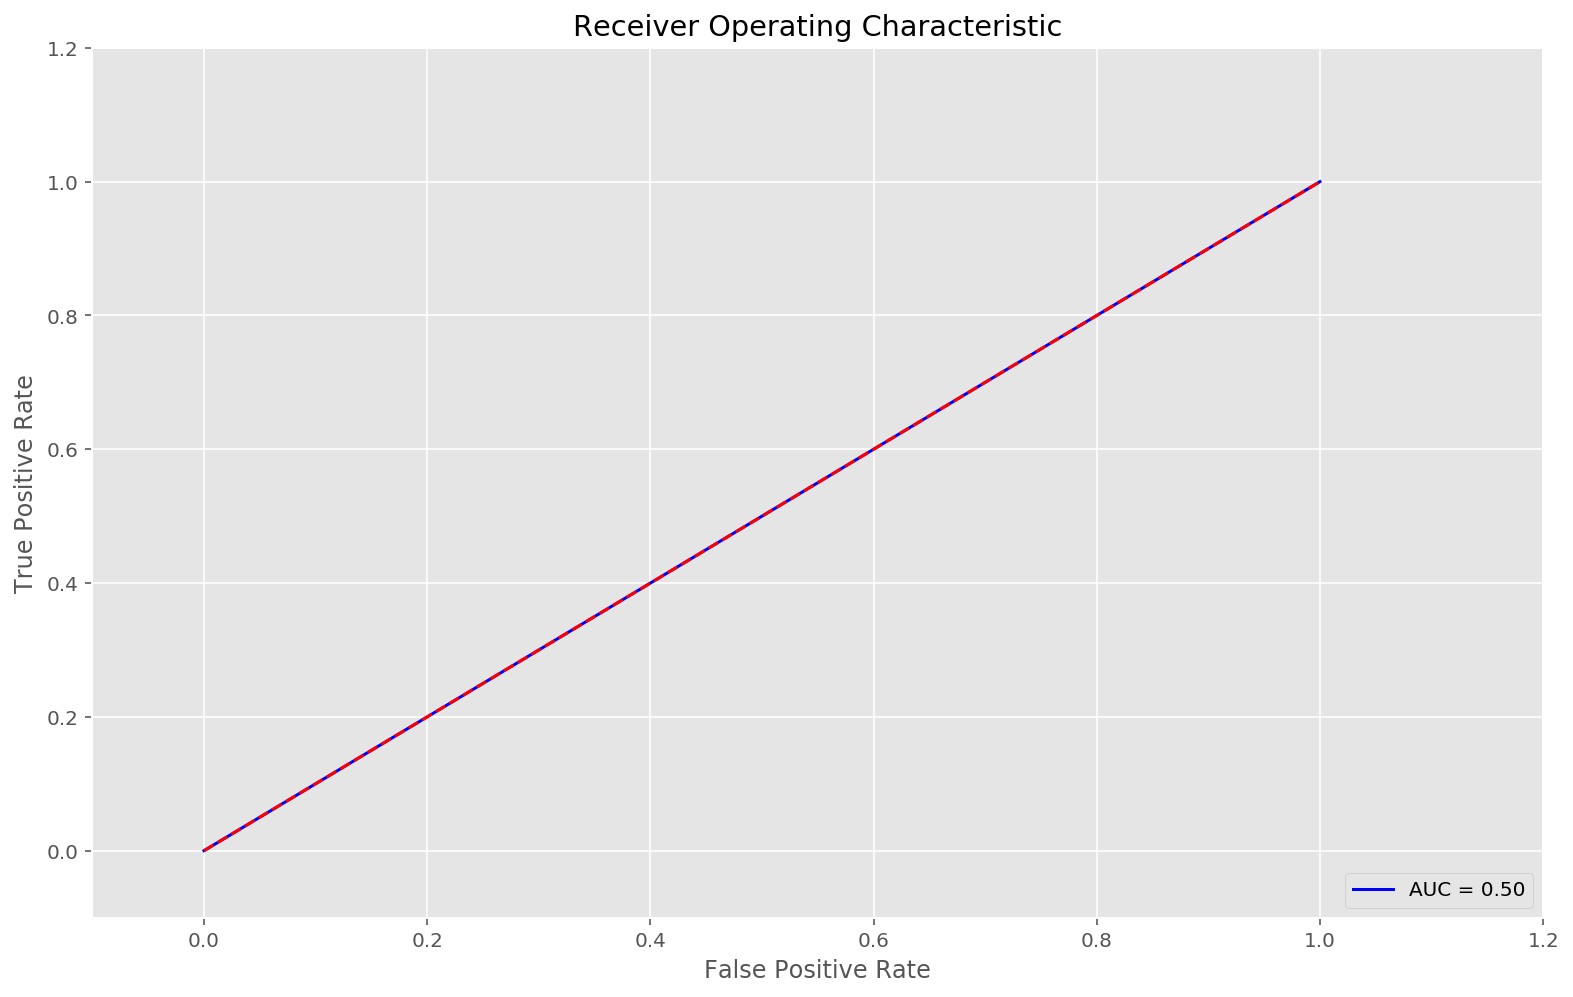

In [27]:
test_features_prepared = rbf_feature.fit_transform(test_features_prepared)
labels_pred = clf.predict(test_features_prepared)
model_performance('Kernel approximation', train_features_prepared, train_labels_prepared, test_labels_prepared, 
                  labels_pred)

In [28]:
clf = RandomForestClassifier()
clf.fit(train_features_prepared, train_labels_prepared)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Model name: Random Forest
Test accuracy (Accuracy Score): 0.759123
Test accuracy (ROC AUC Score): 0.558373
Train accuracy: 0.890019
Area Under the Precision-Recall Curve: 0.160888


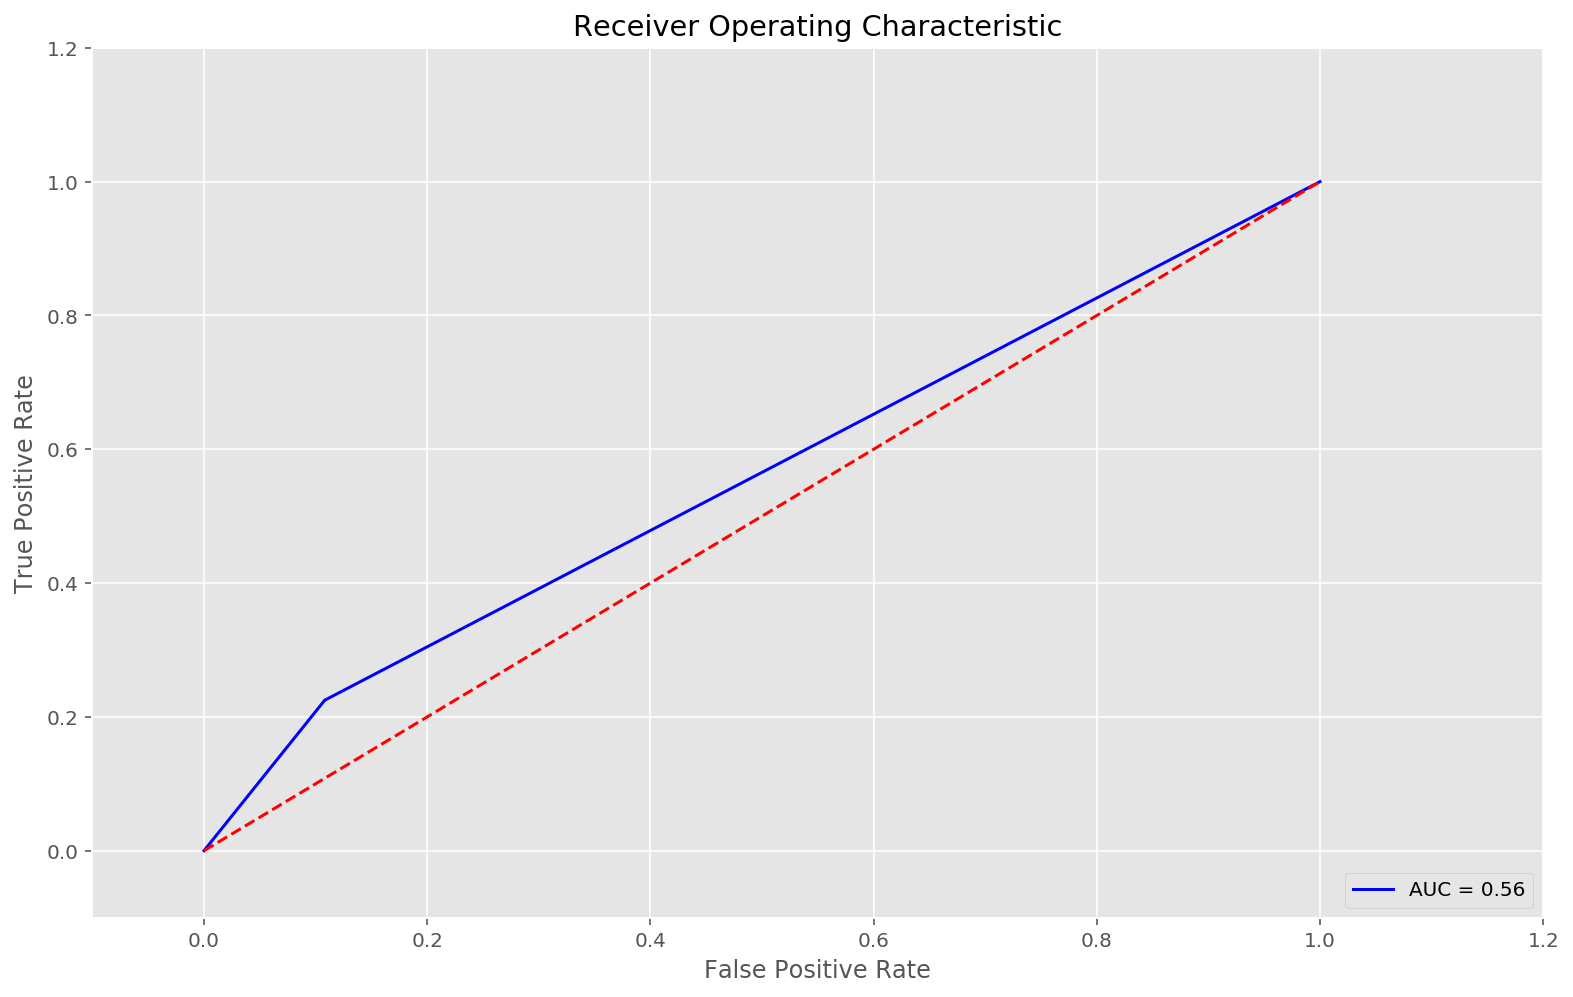

In [29]:
labels_pred = clf.predict(test_features_prepared)
model_performance('Random Forest', train_features_prepared, train_labels_prepared, 
                  test_labels_prepared, labels_pred)

In [30]:
clf = GradientBoostingClassifier(random_state=10, learning_rate=0.1, n_estimators=200, max_depth=5, max_features=10)
clf.fit(train_features_prepared, train_labels_prepared)
labels_pred = clf.predict(test_features_prepared)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model name: Gradient Boosting
Test accuracy (Accuracy Score): 0.798540
Test accuracy (ROC AUC Score): 0.507968
Train accuracy: 0.810594
Area Under the Precision-Recall Curve: 0.111365


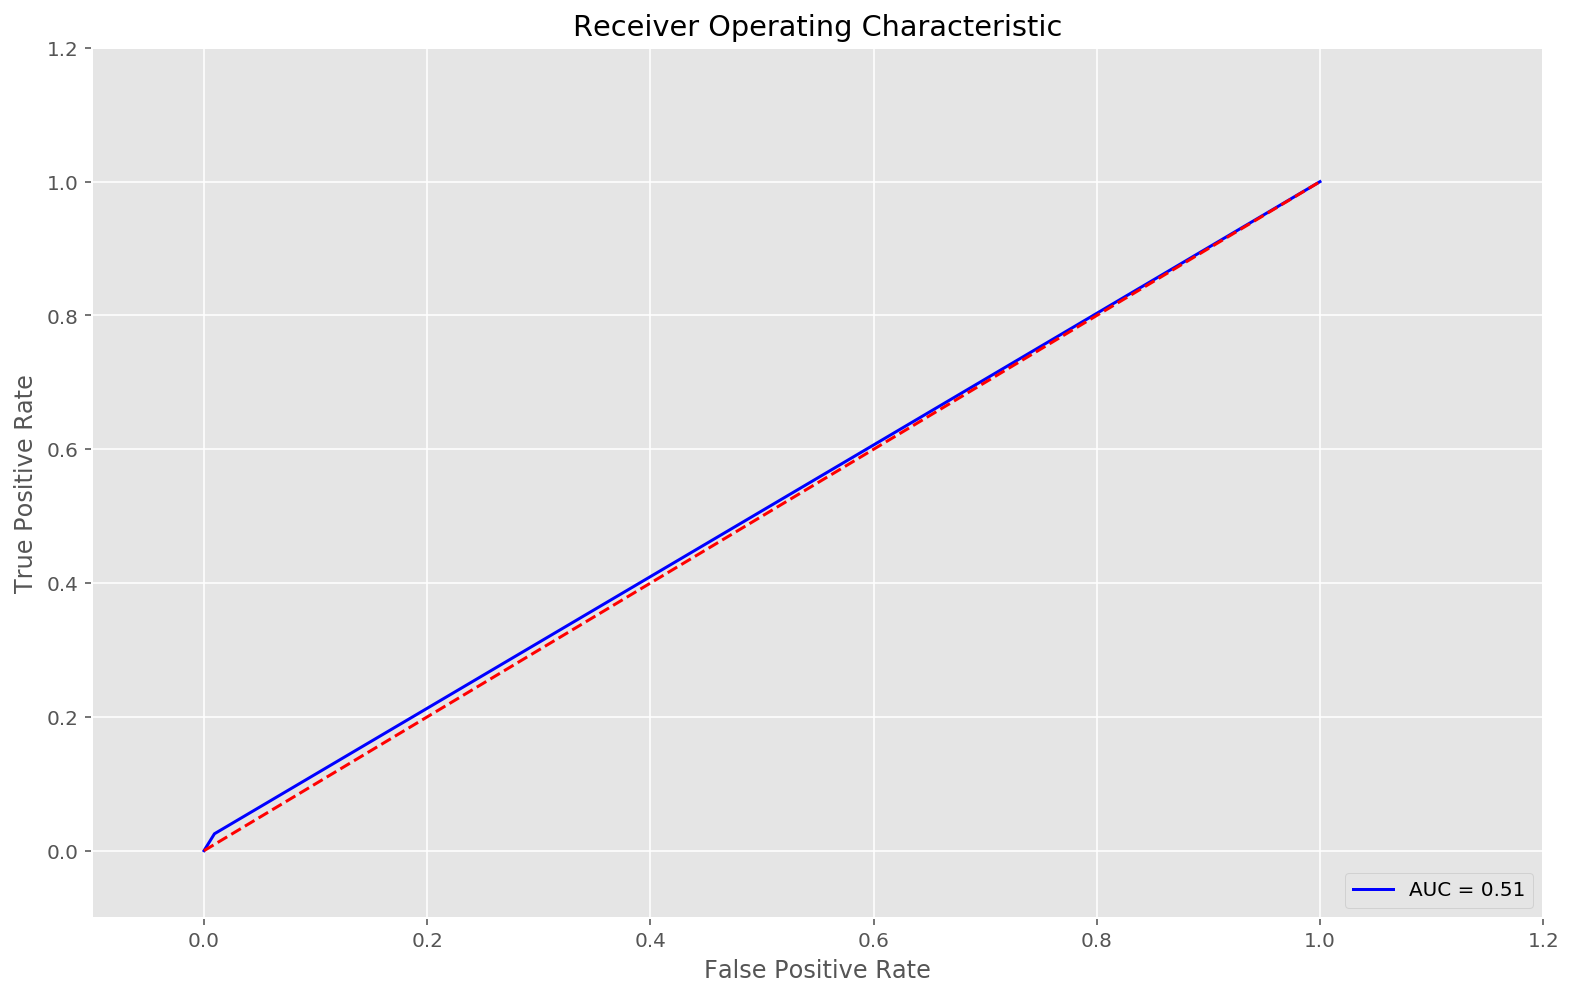

In [31]:
model_performance('Gradient Boosting', train_features_prepared, train_labels_prepared, 
                  test_labels_prepared, labels_pred)

In [ ]:
# Apply grid search to gradient boosting

In [ ]:
# Transform data into PCA